# A Hands-on Tutorial for Bayesian Neural Networks

(Part 1: regression)

[Yingzhen Li](http://yingzhenli.net/home/en/)

(As part of the BNN lecture at [ProbAI 2022](https://probabilistic.ai/))

In this tutorial, you will implement various Bayesian neural network methods based on variational inference.

We will go through regression tasks to see the applications of uncertainty estimation in practice, including a case study on Bayesian optimisation.

**How to use this tutorial notebook?**

*   Read the descriptions in the text;
*   Fill in the missing code whenever you see a block that looks like below:

```
### beginning of your code ###
[insert your own code here]
### end of your code ###
```
There will be hints provided in the code blocks as well to guide you through.

Let us set up the required packages, and then, enjoy 😊

In [29]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

# What is a Bayesian neural network?

In short, a Bayesian neural network (BNN) is a neural network that use (approximate) Bayesian inference for uncertainty estimation. For example, we can treat the NN parameters as random variables and infer them using (approximate) Bayesian posterior inference.

For the mathematical foundation, see [lecture notes here](http://yingzhenli.net/home/pdf/ProbAI2022_lecture_note.pdf).

# Implementing the BNN with mean-field variational inference (MFVI)

In this part, you will implement the Bayes-by-backprop algorithm by [Blundell et al. (2015)](https://arxiv.org/abs/1505.05424), which is doing mean-field variational inference (MFVI) in weight space for Bayesian neural networks.

For the mathematical foundation, see [lecture notes here](http://yingzhenli.net/home/pdf/ProbAI2022_lecture_note.pdf).


## Implementing the ```MFVILinear``` class and construct a BNN

We will implement the MFVI approach in a modular way, so we need a "BNN layer" module ```MFVILinear``` to start with. This will allow us to stack-up many network layers efficiently. Then we will implement the training & testing functions, and test the model's performance with a regression example.

In below block you will implment a BNN layer with mean-field variational inference (MFVI), and more specifically:

* the initialisation of the variational parameters
* the forward pass with Monte Carlo
* the $KL[q||p]$ regularisation term for one layer, i.e., $KL[q(W) || p(W)] + KL[q(b) || p(b)]$

In [30]:
class MFVILinear(nn.Module):
    """Applies a linear transformation to the incoming data: y = xW^T + b, where
    the weight W and bias b are sampled from the q distribution.
    """

    def __init__(self, dim_in, dim_out, prior_weight_std=1.0, prior_bias_std=1.0, init_std=0.05,
                 sqrt_width_scaling=False, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MFVILinear, self).__init__()
        self.dim_in = dim_in  # dimension of network layer input
        self.dim_out = dim_out  # dimension of network layer output

        # define the trainable variational parameters for q distribtuion
        # first define and initialise the mean parameters
        self.weight_mean = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self.bias_mean = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        self._weight_std_param = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self._bias_std_param = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_weight_std /= self.dim_in ** 0.5
        # prior parameters are registered as constants
        self.register_buffer('prior_weight_mean', torch.full_like(self.weight_mean, prior_mean))
        self.register_buffer('prior_weight_std', torch.full_like(self._weight_std_param, prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full_like(self.bias_mean, prior_mean))
        self.register_buffer('prior_bias_std', torch.full_like(self._bias_std_param, prior_bias_std))

    def extra_repr(self):
        s = "dim_in={}, dim_in={}, bias=True".format(self.dim_in, self.dim_out)
        weight_std = self.prior_weight_std.data.flatten()[0]
        if torch.allclose(weight_std, self.prior_weight_std):
            s += f", weight prior std={weight_std.item():.2f}"
        bias_std = self.prior_bias_std.flatten()[0]
        if torch.allclose(bias_std, self.prior_bias_std):
            s += f", bias prior std={bias_std.item():.2f}"
        return s

    def reset_parameters(self, init_std=0.05):
        nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
        bound = self.dim_in ** -0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        ### begin of your code ###
        # hints: Notice that standard deviation > 0 always so we cannot directly treat
        # the standard deviation as a free parameter. Instead we parameterise a free-form
        # parameter self._weight_std_param and then transform it to the standard deviation
        # in the function "weight_std(self)" below. Note that we want to initialise these
        # parameters so that standard deviation of q(W) (and q(b)) is initialised as init_std.
        _init_std_param = np.log(init_std)
        self._weight_std_param.data = torch.full_like(self.weight_mean, _init_std_param)
        self._bias_std_param.data = torch.full_like(self.bias_mean, _init_std_param)

        ### end of your code ###

    # define the q distribution standard deviations with property decorator
    @property
    def weight_std(self):
        ### begin of your code ###
        # hints: depending on how you define self._weight_std_param above, the way
        # you convert self._weight_std_param to weight_std (standard deviation of q(W))
        # will be different.

        weight_std = torch.clamp(torch.exp(self._weight_std_param), min = EPS)

        ### end of your code ###
        return weight_std

    @property
    def bias_std(self):
        ### begin of your code ###

        bias_std = torch.clamp(torch.exp(self._bias_std_param), min=EPS)

        ### end of your code ###
        return bias_std

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q_weight = dist.Normal(self.weight_mean, self.weight_std)
        p_weight = dist.Normal(self.prior_weight_mean, self.prior_weight_std)
        kl = dist.kl_divergence(q_weight, p_weight).sum()
        q_bias = dist.Normal(self.bias_mean, self.bias_std)
        p_bias = dist.Normal(self.prior_bias_mean, self.prior_bias_std)
        kl += dist.kl_divergence(q_bias, p_bias).sum()
        return kl

    # forward pass with Monte Carlo (MC) sampling
    def forward(self, input):
        weight = self._normal_sample(self.weight_mean, self.weight_std)
        bias = self._normal_sample(self.bias_mean, self.bias_std)
        return F.linear(input, weight, bias)

    def _normal_sample(self, mean, std):
        ### begin of your code ###
        # please implement the sampling process for a factorised Gaussian
        return mean + torch.randn_like(mean)*std
        ### end of your code ###

# # construct a BNN
# def make_mfvi_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
#     nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
#     net = nn.Sequential()
    
#     for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
#         net.add_module(f'MFVILinear{i}', MFVILinear(dim_in, dim_out, **layer_kwargs))
#         if i < len(layer_sizes) - 2:
#             net.add_module(f'Nonlinarity{i}', nonlinearity)
#     return net
    

def make_mfvi_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()

    for i in range(len(layer_sizes)-1):
        dim_in, dim_out = layer_sizes[i], layer_sizes[i+1]
        net.add_module(f'MFVILinear{i}', MFVILinear(dim_in, dim_out, **layer_kwargs))
        if i != len(layer_sizes) - 1:
            net.add_module(f'Nonlinarity{i}', nonlinearity)

    return net

In [42]:
layer_sizes = [1, 50, 50, 1]
for i in range(len(layer_sizes)-1):
    dim_in, dim_out = layer_sizes[i], layer_sizes[i+1]
    print(dim_in, dim_out)

1 50
50 50
50 1


We have just defined the ```MFVILinear``` class and ```make_mfvi_bnn``` for network construction.

In below we define the training procedure of a BNN, mainly by defining the training objective. This also involves helper functions that collects the KL regularizers accross layers as well as a prediction function.

In particular, as we work with regression data, we will use Gaussian likelihood, i.e., $p(y | x, \theta) = N(y; f_{\theta}(x), \sigma^2)$ where $f_{\theta}$ is the neural network and $\sigma^2$ is the output variance parameter that we will also optimise.

In [32]:
# collect the kl divergence for all MFVILinear layers
def kl_divergence(bnn):
    kl = 0.0
    for module in bnn:
        if hasattr(module, 'kl_divergence'):
            kl = kl + module.kl_divergence()
    return kl

# define the training function which minimises the negative ELBO
# note that the (tempered) negative ELBO = negative log-likliehood of dataset + beta * KL
# where the neg. log-likelihood *per datapoint* is computed with a function
# nll = data_loss_func(y, y_pred)
# this data_loss_func is to be defined later, depending on the learning task
def train_step(net, opt, data_loss_func, dataloader, N_data, beta=1.0):
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_pred = net(x)
        ### begin of your code ###
        # notice we might use mini-batches, so be careful for the right data-count!

        nll = data_loss_func(y, y_pred).mean()
        kl = kl_divergence(net)
        loss = N_data * nll + beta * kl
    

        ### end of your code ###

        loss.backward()
        opt.step()
    return nll, kl

# now define the data_loss_func that will be used later
# in detail, we will define a Gaussian log-likelihood function below, and then define
# data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
# where log_noise_var is the output noise (log) variance which is a seperate model parameter
# define gaussian log-likelihood
def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist = (y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2*math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# define the prediction function with Monte Carlo sampling using K samples
def predict(bnn, x_test, K=1):
    y_pred = []
    for _ in range(K):
        y_pred.append(bnn(x_test))
    # shape (K, batch_size, y_dim) or (batch_size, y_dim) if K = 1
    return torch.stack(y_pred, dim=0).squeeze(0)

# define the error metrics: RMSE and test negative log-likelihood
# in below functions y_pred should have shape (K, batch_size, y_dim) or (batch_size, y_dim)
def rmse(y, y_pred):
    if len(y_pred.shape) > 2: # using K > 1 MC samples
        y_pred = y_pred.mean(0)
    return (y - y_pred).pow(2).sum(-1).mean().sqrt()

def test_nll(y, y_pred, data_loss_func):
    nll = data_loss_func(y, y_pred)  # with shape (batch_size) or (K, batch_size)
    if len(nll) == 2:  # using K > 1 MC samples
        nll = -torch.logsumexp(-nll, dim=0) + math.log(nll.shape[0]) # Bayesian predictive average
    return nll.mean()

## Testing: a simple regression task
We will run a simple 1-D regression task to test the implemented BNN, in terms of its predictive performance and uncertainty estimation.

Let's get some synthetic data:



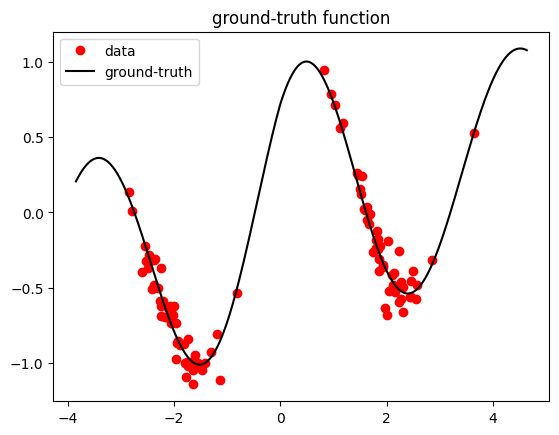

In [33]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None):
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

We set-up the hyper-parameters and build a BNN to be trained.



BNN architecture: 
 Sequential(
  (MFVILinear0): MFVILinear(dim_in=1, dim_in=50, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity0): GELU(approximate='none')
  (MFVILinear1): MFVILinear(dim_in=50, dim_in=1, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity1): GELU(approximate='none')
)


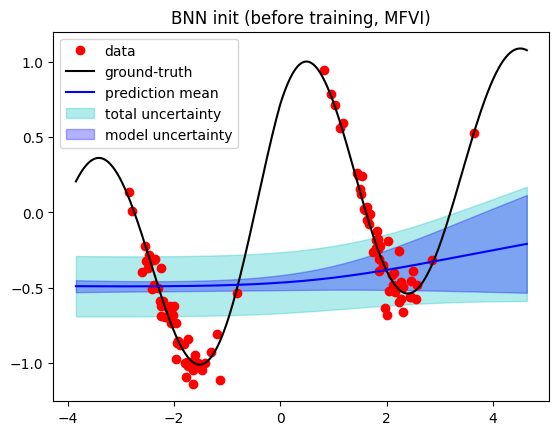

[0.09806591] 0.1 0.05347893508122236


In [34]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
x_dim, y_dim = x_train.shape[1], y_train.shape[1]
# build a BNN, with hidden layer width = h_dim
h_dim = 50
# layer_sizes = [x_dim, h_dim, h_dim, y_dim]
layer_sizes = [x_dim, h_dim, y_dim]
# you can change the activation function here or define your own customized activation
activation=nn.GELU()
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.05,
                'device': device}
mfvi_regression_net = make_mfvi_bnn(layer_sizes, activation=activation, **layer_kwargs) ## I commented this in
# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", mfvi_regression_net) ## and trhis

# plot the BNN prior in function space
K = 50  # number of Monte Carlos samples used in test time
x_test_norm = normalise_data(x_test, dataset.x_mean, dataset.x_std)
x_test_norm = torch.tensor(x_test_norm, ).float().to(device)

def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

def get_regression_results(net, x, K, log_noise_var=None):
    y_pred = predict(net, x, K=K)  # shape (K, N_test, y_dim)
    y_pred_mean = y_pred.mean(0)
    if log_noise_var is not None:
        # note here the preditive std needs to count for output noise variance
        y_pred_std = (y_pred.var(0) + torch.exp(log_noise_var)).sqrt()
    else:
        y_pred_std = y_pred.std(0)
    # unnormalise
    y_pred_mean = unnormalise_data(to_numpy(y_pred_mean), dataset.y_mean, dataset.y_std)
    y_pred_std = unnormalise_data(to_numpy(y_pred_std), 0.0, dataset.y_std)
    return y_pred_mean, y_pred_std

# plot the BNN prior and ground truth
def plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std, title=''):
    plt.plot(x_train, y_train, 'ro', label='data')
    plt.plot(x_test, y_test, 'k-', label='ground-truth')
    plt.plot(x_test, y_pred_mean, 'b-', label='prediction mean')
    # plot the uncertainty as +- 2 * std
    # first for the total uncertainty (model/epistemic + data/aleatoric)
    plt.fill_between(x_test[:,0], y_pred_mean[:,0]-2*y_pred_std[:,0],
                     y_pred_mean[:,0]+2*y_pred_std[:,0],
                     color='c', alpha=0.3, label='total uncertainty')
    # then for the model/epistemic uncertainty only
    plt.fill_between(x_test[:,0], y_pred_mean[:,0]-2*y_pred_std_noiseless[:,0],
                     y_pred_mean[:,0]+2*y_pred_std_noiseless[:,0],
                     color='b', alpha=0.3, label='model uncertainty')
    plt.legend()
    plt.title(title)
    plt.show()

y_pred_mean, y_pred_std_noiseless = get_regression_results(mfvi_regression_net, x_test_norm, K) ## and this
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, MFVI)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

Now define the data loss (i.e., negative log-likelihood) and train the BNN.

Epoch 100, nll=7.101660251617432, kl=383.6115417480469
Epoch 200, nll=5.888368129730225, kl=373.54473876953125
Epoch 300, nll=4.79028844833374, kl=364.3094787597656
Epoch 400, nll=3.808999538421631, kl=355.69580078125
Epoch 500, nll=3.368504285812378, kl=347.2218933105469
Epoch 600, nll=3.0971243381500244, kl=338.73431396484375
Epoch 700, nll=2.571873426437378, kl=330.0254821777344
Epoch 800, nll=2.4104111194610596, kl=321.16278076171875
Epoch 900, nll=2.261718511581421, kl=312.2870788574219
Epoch 1000, nll=3.1445388793945312, kl=303.4456481933594
Epoch 1100, nll=2.2519001960754395, kl=294.84356689453125
Epoch 1200, nll=1.9801678657531738, kl=286.2324523925781
Epoch 1300, nll=1.9052321910858154, kl=277.9282531738281
Epoch 1400, nll=2.344888210296631, kl=269.41162109375
Epoch 1500, nll=1.6981068849563599, kl=261.22540283203125
Epoch 1600, nll=1.6139707565307617, kl=253.4522705078125
Epoch 1700, nll=2.094733715057373, kl=245.81399536132812
Epoch 1800, nll=1.5234664678573608, kl=238.81567

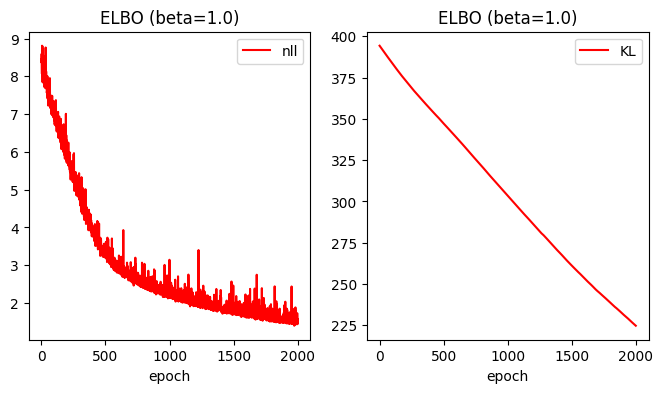

In [35]:
# define the training function
def train_network(net, opt, dataloader, data_loss_func, learning_rate=1e-3,
                  N_epochs=2000, beta=1.0, verbose=True):
    net.train()
    logs = []
    for i in range(N_epochs):
        nll, kl = train_step(net, opt, data_loss_func, dataloader,
                          N_data=len(dataloader.dataset), beta=beta)
        logs.append([to_numpy(nll), to_numpy(kl)])
        if (i+1) % 100 == 0 and verbose:
            print("Epoch {}, nll={}, kl={}".format(i+1, logs[-1][0], logs[-1][1]))
    return np.array(logs)

# start training
learning_rate = 1e-3
params = list(mfvi_regression_net.parameters()) + [log_noise_var]
opt = torch.optim.Adam(params, lr=learning_rate)
# define the regression loss: negative gaussian log-likelihood
data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
# hyper-parameters of training
beta = 1.0
N_epochs = 2000
# the training loop starts
logs = train_network(mfvi_regression_net, opt, dataloader, data_loss_func,
                     beta=beta, verbose=True, N_epochs=N_epochs)

# plot the training curve
def plot_training_loss(logs, beta):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(np.arange(logs.shape[0]), logs[:, 0], 'r-', label='nll')
    ax2.plot(np.arange(logs.shape[0]), logs[:, 1], 'r-', label='KL')
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_title('ELBO (beta={})'.format(beta))
    ax2.set_title('ELBO (beta={})'.format(beta))
    plt.show()

plot_training_loss(logs, beta)

Training is now finished, let's plot the predictions again, but now it shows the mean & std of Bayesian predictive inference.

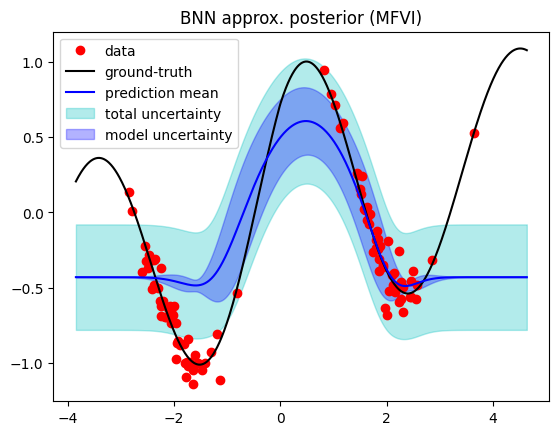

[0.17500159] 0.1 0.057035476441487515


In [36]:
y_pred_mean, y_pred_std_noiseless = get_regression_results(mfvi_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN approx. posterior (MFVI)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

**playground**

You can test various hyper-parameter settings and see how they would affect the regression results.

In particular, you can go back to previous code blocks and change the settings e.g,:

1. Change the depth of the network, by changing the list of ```layer_sizes```;
2. Activation functions: try e.g., ```nn.Tanh()``` or ```nn.ReLU()``` or the below ```Sine``` activation (copy-paste the code below to the place when you define the activation function);
3.   Training epochs: try setting different values for ```N_epochs``` when calling ```train_network()```, e.g., ```N_epochs = 1000``` vs ```N_epochs = 10000```, and see what happens to the training curves;
4.   Tempered ELBO: try using different values of ```beta```, e.g., ```beta = 0.1``` vs ```beta = 10```;
5.   Prior settings: try ```sqrt_width_scaling=True```;
6.   Initialisation of the q standard deviation ```init_std```.

Come up with you own conclusions: which settings work well?

In [37]:
# copy-paste below code to the appropriate place, and call it by
# activation = Sine()
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()
    def forward(self, x):
        return torch.sin(x)

# Using other q distributions?

Hopefully from above tests, you can see that MFVI works but it needs careful settings of the hyper-parameters (i.e., tricks that are mostly hidden in paper appendices).

A natural question is to ask whether other design of the q distribution would return better results. Within the Gaussian family, Gaussians with full-rank covariance matrices are more expressive than factorised Gaussians. But at the same time, it requires much more variational parameters if we were to use full covariance Gaussians for every layer. For example, a hidden layer with ```dim_in = dim_out = 50``` would need $50 \times 50 = 2500$ parameters for parameterising the mean, but $\sum_{i=1}^{50\times 50} i = 3126250$ parameters for parameterising the (symmetric) full covariance matrix! Therefore, when selecting the q distribution family, one needs to also consider the computational & memory costs for such approximation.

In below we will implement 2 "economic" solutions:

1.   The so-called "last-layer BNN" approach: only apply full-covariance Gaussian posterior approximation to the last layer of the network, and use MLE/MAP solutions for the previous layers.
2.   Monte Carlo dropout (MC-dropout).

For mathematical foundations, see [lecture notes here](http://yingzhenli.net/home/pdf/ProbAI2022_lecture_note.pdf).


## Last-layer BNN with full-covariace Gaussian approximation

For the "last-layer BNN" method we need to use a full-covariance Gaussian posterior approximation for the output layer of the network.

In below block you will implment a BNN layer with variational inference and Gaussian q with **full covariance matrix**, and more specifically:

* the initialisation of the variational parameters
* the forward pass with Monte Carlo
* the $KL[q||p]$ regularisation term for one layer

In [38]:
class FullCovGaussianLinear(nn.Module):
    """Applies a linear transformation to the incoming data: y = xW^T + b, where
    the weight W and bias b are sampled from the q distribution.
    """

    def __init__(self, dim_in, dim_out, prior_weight_std=1.0, prior_bias_std=1.0, init_std=0.5,
                 sqrt_width_scaling=False, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianLinear, self).__init__()
        self.dim_in = dim_in  # dimension of network layer input
        self.dim_out = dim_out  # dimension of network layer output

        # define the trainable variational parameters for q distribtuion
        # first define and initialise the mean parameters
        self.weight_mean = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self.bias_mean = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        # then define and initialise the parameters for covariance matrix
        # note here that we concatenate all the parameters in W and b and work with their covariances
        # in particular, we would like to parameterise the Cholesky factor L of the covariance
        # so that LL^T = covariance matrix of q(W, b)
        num_params = dim_out * dim_in + dim_out # total number of parameters
        self._cov_diag = nn.Parameter(torch.empty((num_params,), **factory_kwargs))
        self._cov_tril = nn.Parameter(torch.empty((num_params, num_params), **factory_kwargs))
        self.reset_parameters()

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_weight_std /= self.dim_in ** 0.5
        self.prior_weight_std = prior_weight_std
        self.prior_bias_std = prior_bias_std
        # prior parameters are registered as constants
        self.register_buffer("prior_mean", torch.full((num_params,), prior_mean, **factory_kwargs))
        prior_weight_std = torch.full_like(self.weight_mean, prior_weight_std)
        prior_bias_std = torch.full_like(self.bias_mean, prior_bias_std)
        prior_std_diag = torch.concat((prior_weight_std.flatten(), prior_bias_std.flatten()))
        self.register_buffer('prior_scale_tril', prior_std_diag.diag_embed())

    def extra_repr(self):
        s = "dim_in={}, dim_out={}, bias=True".format(self.dim_in, self.dim_out)
        s += f", weight prior std={self.prior_weight_std:.2f}"
        s += f", bias prior std={self.prior_bias_std:.2f}"
        return s

    def reset_parameters(self, init_std=0.5):
        nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
        bound = self.dim_in ** -0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        _init_std_param = math.log(math.expm1(init_std))
        self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
        self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator
    @property
    def mean(self):
        # flatten the weight matrix into a vector
        return torch.concat((self.weight_mean.flatten(), self.bias_mean.flatten()))

    @property
    def scale_tril(self):
        # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
        # Only taking values below the main diagonal? no it takes everything below diagonal
        return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.scale_tril)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_scale_tril)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    # forward pass with Monte Carlo (MC) sampling
    def forward(self, input):
        weight, bias = self._normal_sample(self.mean, self.scale_tril)
        return F.linear(input, weight, bias)

    def _normal_sample(self, mean, scale_tril):
        sample = mean + scale_tril @ torch.randn_like(mean)
        # chunk out the weight and bias
        weight_vec, bias = torch.split(sample, [self.dim_in * self.dim_out, self.dim_out])
        return weight_vec.reshape(self.dim_out, self.dim_in), bias

# now also define a function to make a network with only last layer using variational inference
def make_last_layer_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()
    linear_layer_kwargs = {}
    if 'device' in layer_kwargs:
        linear_layer_kwargs['device'] = layer_kwargs['device']
    for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-2], layer_sizes[1:-1])):
        net.add_module(f'Linear{i}', nn.Linear(dim_in, dim_out, **linear_layer_kwargs))
        if i < len(layer_sizes) - 2:
            net.add_module(f'Nonlinarity{i}', nonlinearity)
    # last layer using variational inference with full covariance matrix Gaussian
    net.add_module(f'FullCovGaussianLinear{i+1}',
                   FullCovGaussianLinear(layer_sizes[-2], layer_sizes[-1], **layer_kwargs))
    return net

# construct a BNN
def make_full_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()

    for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        net.add_module(f'FullCovGaussianLinear{i}', FullCovGaussianLinear(dim_in, dim_out, **layer_kwargs))
        if i < len(layer_sizes) - 2:
            net.add_module(f'Nonlinarity{i}', nonlinearity)
            
    return net


Now we can run the same regression test again and see how the above full-covariance approximation method compare with the MFVI approach above.

BNN architecture: 
 Sequential(
  (Linear0): Linear(in_features=1, out_features=50, bias=True)
  (Nonlinarity0): GELU(approximate='none')
  (Linear1): Linear(in_features=50, out_features=50, bias=True)
  (Nonlinarity1): GELU(approximate='none')
  (FullCovGaussianLinear2): FullCovGaussianLinear(dim_in=50, dim_out=1, bias=True, weight prior std=1.00, bias prior std=1.00)
)


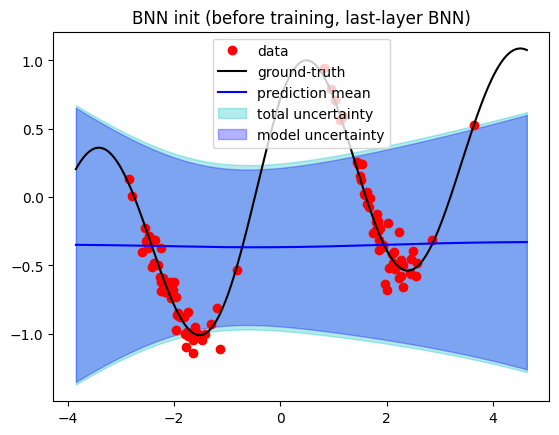

[0.09806591] 0.1 0.3576758052890226


In [39]:
# build a last-layer-BNN with 2-hidden-layers, with hidden layer width = h_dim
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here
activation=nn.GELU()
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.5,
                'device': device}
last_layer_bnn_regression_net = make_last_layer_bnn(layer_sizes, activation=activation, **layer_kwargs)
# we assume a Gaussian likelihood with homogeneuous noise
last_layer_bnn_log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", last_layer_bnn_regression_net)

y_pred_mean, y_pred_std_noiseless = get_regression_results(last_layer_bnn_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*last_layer_bnn_log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, last-layer BNN)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

In [40]:
'''
full bnn testing
'''

# build a last-layer-BNN with 2-hidden-layers, with hidden layer width = h_dim
h_dim = 20
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here
activation=nn.GELU()
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.5,
                'device': device}
full_layer_bnn_regression_net = make_full_bnn(layer_sizes, activation=activation, **layer_kwargs)
# we assume a Gaussian likelihood with homogeneuous noise
full_layer_bnn_log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", full_layer_bnn_regression_net)

y_pred_mean, y_pred_std_noiseless = get_regression_results(full_layer_bnn_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*full_layer_bnn_regression_net)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, last-layer BNN)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

BNN architecture: 
 Sequential(
  (FullCovGaussianLinear0): FullCovGaussianLinear(dim_in=1, dim_out=20, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity0): GELU(approximate='none')
  (FullCovGaussianLinear1): FullCovGaussianLinear(dim_in=20, dim_out=20, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity1): GELU(approximate='none')
  (FullCovGaussianLinear2): FullCovGaussianLinear(dim_in=20, dim_out=1, bias=True, weight prior std=1.00, bias prior std=1.00)
)


TypeError: unsupported operand type(s) for *: <class 'torch.nn.modules.container.Sequential'> and <class 'float'>

BNN architecture: 
 Sequential(
  (FullCovGaussianLinear0): FullCovGaussianLinear(dim_in=1, dim_out=50, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity0): GELU(approximate='none')
  (FullCovGaussianLinear1): FullCovGaussianLinear(dim_in=50, dim_out=50, bias=True, weight prior std=1.00, bias prior std=1.00)
  (Nonlinarity1): GELU(approximate='none')
  (FullCovGaussianLinear2): FullCovGaussianLinear(dim_in=50, dim_out=1, bias=True, weight prior std=1.00, bias prior std=1.00)
)


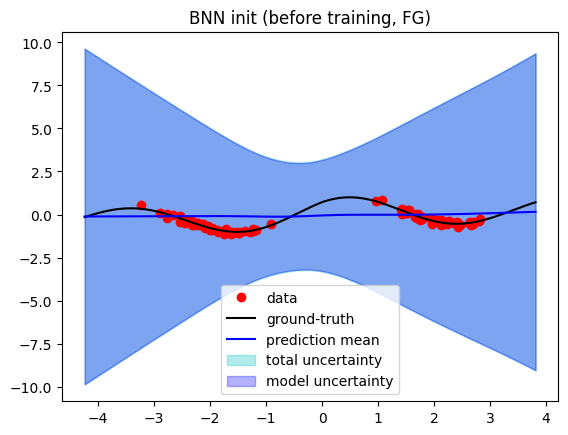

[0.25698624] 0.1 2.9238865116381962


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
x_dim, y_dim = x_train.shape[1], y_train.shape[1]
# build a BNN, with hidden layer width = h_dim
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here or define your own customized activation
activation=nn.GELU()
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.05,
                'device': device}
full_layer_bnn_regression_net = make_full_bnn(layer_sizes, activation=activation, **layer_kwargs) ## I commented this in
# we assume a Gaussian likelihood with homogeneuous noise
full_layer_bnn_log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", full_layer_bnn_regression_net) ## and trhis

# plot the BNN prior in function space
K = 50  # number of Monte Carlos samples used in test time
x_test_norm = normalise_data(x_test, dataset.x_mean, dataset.x_std)
x_test_norm = torch.tensor(x_test_norm, ).float().to(device)

y_pred_mean, y_pred_std_noiseless = get_regression_results(full_layer_bnn_regression_net, x_test_norm, K) ## and this
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*full_layer_bnn_log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, FG)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

In [ ]:
full_layer_bnn_regression_net[2]

FullCovGaussianLinear(dim_in=50, dim_out=50, bias=True, weight prior std=1.00, bias prior std=1.00)

Now start training for this "last-layer-BNN" network.


Epoch 100, nll=51.771888732910156, kl=1059.26220703125
Epoch 200, nll=300.78155517578125, kl=1243.7904052734375
Epoch 300, nll=15.798201560974121, kl=1424.9427490234375


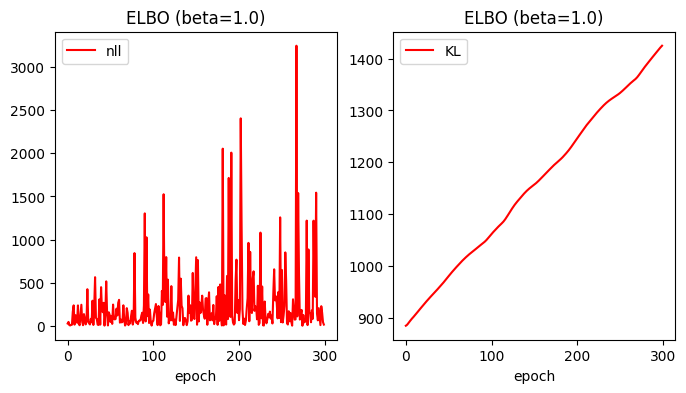

In [ ]:
# start training
learning_rate = 1e-3
params = list(full_layer_bnn_regression_net.parameters()) + [full_layer_bnn_log_noise_var]
full_layer_bnn_opt = torch.optim.Adam(params, lr=learning_rate)
data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, full_layer_bnn_log_noise_var)

beta = 1.0
N_epochs = 300
logs = train_network(full_layer_bnn_regression_net, full_layer_bnn_opt,
                     dataloader, data_loss_func, beta=beta, verbose=True, N_epochs=N_epochs)
# plot the training curve
plot_training_loss(logs, beta)

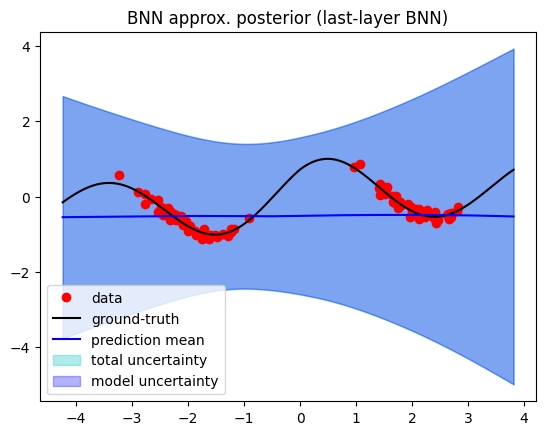

[0.10318438] 0.1 1.347082771270543


In [ ]:
# plot the prediction results
y_pred_mean, y_pred_std_noiseless = get_regression_results(full_layer_bnn_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*full_layer_bnn_log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN approx. posterior (last-layer BNN)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

Similar to the MFVI tests, you can also test various hyper-parameter settings and see how they would affect the regression results using "last-layer BNN".

## Monte Carlo dropout (MC-dropout)

For the mathematical foundation, see [lecture notes here](http://yingzhenli.net/home/pdf/ProbAI2022_lecture_note.pdf).

For the MC-dropout method with dropout probability $p$, the q distribution is a mixture of delta measures. Specifically, for a layer with parameters $\{W, b \}, W \in \mathbb{R}^{d_{out} \times d_{in}}, b \in \mathbb{R}^{d_{out}}$, the q distribution is

$q(W, b) = \prod_{i=1}^{d_{out}}q(W_i, b_i),$

$q(W_i, b_i) = p \delta(W_i = 0, b_i = 0) + (1 - p) \delta(W_i = M_i, b_i = m_i),$

with variational parameter for the layer as $\{M, m \}, M \in \mathbb{R}^{d_{out} \times d_{in}}, m \in \mathbb{R}^{d_{out}}$. This means there are two equivalent way to compute $\mathbb{E}_q[\log p(y|x, \theta)]$ with Monte Carlo: for the forward pass of a layer, below computations are equivalent:

1.   **drop weights**: sample $W, b \sim q(W, b)$, then compute $y = xW^T + b$;
2.   **drop units**: compute $\hat{y} = x M^T + m$, then apply dropout $y = \text{dropout}(\hat{y}; p)$.

The $KL[q||p]$ regularizer for MC-dropout is ill-defined for Gaussian prior $p(\theta)$. In practice this is replaced by an $\ell_2$ regularizer, i.e., $\frac{1-p}{2\sigma^2_{\text{prior}}}|| M ||_2^2$ for the weight variational parameter $M$ (and similarly for $m$).

In below block you will implment a BNN layer with MC-dropout, and more specifically:

* the forward pass with Monte Carlo: you are asked to implement both "drop weight" and the "drop unit" approach.
* the $KL[q||p]$ regularisation term for one layer: use the $\ell_2$ regularizer

In [ ]:
class MCDropoutLinear(nn.Module):
    """Applies a linear transformation to the incoming data: y = xW^T + b, where
    the weight W and bias b are sampled from the q distribution.
    """

    def __init__(self, dim_in, dim_out, prior_weight_std=1.0, prior_bias_std=1.0, dropout_prob=0.1,
                 sqrt_width_scaling=False, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(MCDropoutLinear, self).__init__()
        self.dim_in = dim_in  # dimension of network layer input
        self.dim_out = dim_out  # dimension of network layer output
        self.dropout_prob = dropout_prob
        # the boolean indicator for the dropout implementation
        # if true then run the "drop weight" forward pass, else run "drop unit"
        self.drop_weight = False

        # define the trainable variational parameters for q distribtuion
        # first define and initialise the mean parameters
        self.weight = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self.bias = nn.Parameter(torch.empty(dim_out, **factory_kwargs))
        self.reset_parameters()

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_weight_std /= self.dim_in ** 0.5
        # prior parameters are registered as constants
        self.register_buffer('prior_weight_mean', torch.full_like(self.weight, prior_mean))
        self.register_buffer('prior_weight_std', torch.full_like(self.weight, prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full_like(self.bias, prior_mean))
        self.register_buffer('prior_bias_std', torch.full_like(self.bias, prior_bias_std))

    def extra_repr(self):
        s = "dim_in={}, dim_in={}, bias=True".format(self.dim_in, self.dim_out)
        weight_std = self.prior_weight_std.data.flatten()[0]
        if torch.allclose(weight_std, self.prior_weight_std):
            s += f", weight prior std={weight_std.item():.2f}"
        bias_std = self.prior_bias_std.flatten()[0]
        if torch.allclose(bias_std, self.prior_bias_std):
            s += f", bias prior std={bias_std.item():.2f}"
        return s

    def reset_parameters(self, init_std=0.5):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        bound = self.dim_in ** -0.5
        nn.init.uniform_(self.bias, -bound, bound)

    def set_dropout_mode(self, drop_weight=False):
        self.drop_weight = drop_weight

    # KL divergence KL[q||p]: for MCDropout this returns an l2 regulariser
    def kl_divergence(self):
        ### begin of your code ###
        # hints: using an appropriate l2 regulariser as the kl

        kl_weight =
        kl_bias =

        ### end of your code ###
        return kl_weight + kl_bias

    # forward pass with Monte Carlo (MC) sampling
    def forward(self, input):
        ### begin of your code ###
        # hints: your can implement the dropout method using an appropriate masking matrix
        if self.drop_weight:  # drop weight method
            out =

        else: # drop unit method
            out =

        ### end of your code ###
        return out

# construct a BNN
def make_mcdropout_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()
    for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        net.add_module(f'MCDropoutLinear{i}', MCDropoutLinear(dim_in, dim_out, **layer_kwargs))
        if i < len(layer_sizes) - 2:
            net.add_module(f'Nonlinarity{i}', nonlinearity)
    return net

SyntaxError: invalid syntax (2130958623.py, line 56)

Now we can run the same regression test again and see how the MC-dropout method compare with the other approaches above.

In [ ]:
# build a BNN with 2-hidden-layers, with hidden layer width = h_dim
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here
activation=nn.GELU()
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'dropout_prob': 0.1,
                'device': device}
mcdropout_bnn_regression_net = make_mcdropout_bnn(layer_sizes, activation=activation, **layer_kwargs)
# we assume a Gaussian likelihood with homogeneuous noise
mcdropout_bnn_log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", mcdropout_bnn_regression_net)

def set_dropout_mode(bnn, drop_weight=False):
    print("set the dropout mode: drop_weight={}".format(drop_weight))
    for module in bnn:
        if hasattr(module, 'set_dropout_mode'):
            module.set_dropout_mode(drop_weight)

set_dropout_mode(mcdropout_bnn_regression_net, drop_weight=True)
y_pred_mean, y_pred_std_noiseless = get_regression_results(mcdropout_bnn_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*mcdropout_bnn_log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN init (before training, MC-dropout)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

Now start training for this "MC-dropout BNN" network.

In [ ]:
# start training
learning_rate = 1e-3
params = list(mcdropout_bnn_regression_net.parameters()) + [mcdropout_bnn_log_noise_var]
mcdropout_bnn_opt = torch.optim.Adam(params, lr=learning_rate)
data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, mcdropout_bnn_log_noise_var)
set_dropout_mode(mcdropout_bnn_regression_net, drop_weight=False)

beta = 1.0
N_epochs = 2000
logs = train_network(mcdropout_bnn_regression_net, mcdropout_bnn_opt,
                     dataloader, data_loss_func, beta=beta, verbose=True, N_epochs=N_epochs)
# plot the training curve
plot_training_loss(logs, beta)

Training is now finished.

Let's plot the predictions again, and compare it with the results above.

In [ ]:
# plot the prediction results
set_dropout_mode(mcdropout_bnn_regression_net, drop_weight=True)
y_pred_mean, y_pred_std_noiseless = get_regression_results(mcdropout_bnn_regression_net, x_test_norm, K)
model_noise_std = unnormalise_data(to_numpy(torch.exp(0.5*mcdropout_bnn_log_noise_var)), 0.0, dataset.y_std)
y_pred_std = np.sqrt(y_pred_std_noiseless ** 2 + model_noise_std**2)
plot_regression(x_train, y_train, x_test, y_pred_mean, y_pred_std_noiseless, y_pred_std,
                title='BNN approx. posterior (MC-dropout)')
print(model_noise_std, noise_std, y_pred_std_noiseless.mean())

Similar to previous tests, you can also test various hyper-parameter settings and see how they would affect the regression results using MC-dropout.

In particular, try setting different value for ```dropout_prob``` in ```layer_kwargs```.

Also you can try using "drop unit" forward pass when visualising the results, by using

```set_dropout_mode(mcdropout_bnn_regression_net, drop_weight=False)```

You can also try using "drop weight" forward pass when training:

```set_dropout_mode(mcdropout_bnn_regression_net, drop_weight=True)```

By doing so you'll see some visual differences in terms of learning curves and posterior predictive mean/std visualisations. Can you explain that?

# Case study 1: Bayesian optimisation

### What is Bayesian optimisation (BO)?

(Feel free to skip this part if you already understand the idea.)

Assume you are interested in optimising a function $x^* = \arg\max f_0(x)$, but you don't actually know the analytic form of $f(x)$. Rather, you only have access of it as a "black-box", where you provide an input $x$ to this "black-box", and it will return you a (noisy version of) output $y = f_0(x) + \text{noise}$.

Bayesian optimisation (BO) is a class of methods that tackle this challenge.

To motivate BO, let's imagine you already have a set of datapoints $D = \{ (x_n, y_n) \}_{n=1}^N$ collected by sending the queries $x_1, ..., x_N$ to the above mentioned "black-box". Then we can fit a *surrogate function* $f_{\theta}(x)$ to data. In large data limit $N \rightarrow +\infty$, with flexible enough model, we expect $f_{\theta}(x)$ to be very close, if not identical, to the ground-truth function $f_0(x)$. In such case we can solve the optimisation problem by finding $x^* = \arg\max f_{\theta}(x)$ instead, which is tractable.

However, in practice we don't have a big dataset to train the surrogate model. This is expecially the case if the "black-box" corresponds to an expensive experiment (e.g., training a Transformer network where $x$ represents the hyper-parameter settings). In such scenario $f_{\theta}(x)$ will be quite different from $f(x)$ in most of the unseen input locations.

The key idea of BO is to optimise $f_0$ using "helps" from this surrogate by taking the uncertainty of model fitting into account, and it aims to find the optimum of $f_0$ with least amount of queries to the expensive "black-box". Specifically, there are 3 ingredients of an BO method:

1.   Acquisition function: using the current estimated surrogate function $f_{\theta}(x)$ and its uncertainty estimate to compute an acquisition function;
2.   Query the "black-box": find the next input to query by maximising the acquisition function;
3.   Surrogate model update: given new queried result and historical data, update the surrogate model and its uncertainty estimate.

At the beginning since the model is uncertain, a good acquisition function will take uncertainty into account and encourage "exploration", i.e., querying inputs at different locations.

As we collect more data, with proper Bayesian posterior updates, the surrogate model $f_{\theta}$ will become closer and closer to the ground-truth function $f_0$ and the uncertainty will be reduced.

So at some point, the model will become certain about its output, and a good acquisition function will also enable "exploitation" at this stage, to seek for the optimum of the surrogate function $f_{\theta}$ as to solve the original optimization problem.

### The Upper Confidence Bound (UCB) method

The UCB is an acquisition function that uses both mean prediction and uncertainty. Specifically, assume the surrogate model provides both mean $m(x)$ and standard deviation $\sigma(x)$ for a given input $x$, then the UCB acquisition function is the following:

$$UCB(x) = m(x) + \beta \sigma(x).$$

And the query procedure will pick the next query input as $x = \arg\max UCB(x)$.

Initially, $\sigma(x)$ can be quite large for many regions, meaning that UCB will mainly explore. As we collect more data, $\sigma(x)$ will decrease around the regions that have been searched, and this allows the algorithm to

1.   ignore some searched regions where the model confidently thinks their function value is small;
2.   exploit some other searched regions where the model confidently believes the optimum might be there;
3.   explore some other promising regions that has not been searched before.

Here $\beta$ a hyper-parameter specified by the user at a time, to achieve a desired balance between exploration ($\sigma(x)$) and exploitation ($m(x)$). When $\beta = 0$, it means we trust the surrogate model and exploit on that. When $\beta$ is large, we allow the query process to focus on regions that have large $\sigma(x)$ value (where the model is most uncertainty about). For optimal BO, this $\beta$ coefficient will decrease during time; for simplicity, in this demo we only consider a fixed value of $\beta$.

First we implement the ```ucb``` acquisition function as mentioned above.

In [ ]:
# the UCB acquisition function
def ucb(net, x, beta, K):
    ### begin of your code ###
    # hint: do K times of forward passes and then compute the mean and std
    # final results should have shape (N, 1) with x having shape (N, dim_x)

    y_pred_mean =
    y_pred_std =

    ### end of your code ###
    return y_pred_mean + math.sqrt(beta) * y_pred_std, y_pred_mean, y_pred_std

# some helper function
def get_next_query(net, x, acquisition_func, **kwargs):
    # search for the next query point in x using the acquisition function
    # and here we also assume that x_dim = 1
    f, y_pred_mean, y_pred_std = acquisition_func(net, x, **kwargs)  # shape (N, 1)
    next_query = x[torch.argmax(f[:, 0])].unsqueeze(0)
    return next_query, f, y_pred_mean, y_pred_std

def query_oracle(x, oracle_func, noise_std=None):
    # given input, query the oracle function (potentially with noise)
    y = oracle_func(x)
    if noise_std is not None and noise_std > EPS:
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return y

def reset_parameters(bnn, init_std):
    print("re-initialise the parameters with init_std={}".format(init_std))
    for module in bnn:
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters(init_std)

Now let's implement the main loop of BO.

In [ ]:
# now define the Bayesian optimisation search
def bayesian_optimisation(net, log_noise_var, oracle_func, acquisition_func, x, x_init, T,
                          noise_std = None, init_std = 0.1, N_epochs = 1000, **kwargs):
    # we start from a number of observations to initialise the dataset
    y_init = query_oracle(x_init, oracle_func, noise_std)
    observations = regression_data(x_init, y_init)
    # preparing the query candidates
    x_norm = normalise_data(x, observations.x_mean, observations.x_std)
    x_tensor = torch.tensor(x_norm).float().to(device)
    # now start the loop of BO for T steps
    acquisition_func_list = []
    mean_func_list = []; std_func_list = []
    for t in range(T):
        dataloader = DataLoader(observations, batch_size=min(100, len(observations)), shuffle=True)
        # train the network
        print("update BNN posterior...")
        params = list(net.parameters()) + [log_noise_var]
        opt = torch.optim.Adam(params, lr=1e-3)
        data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
        # if using MC-dropout, use "drop unit" mode for training
        set_dropout_mode(net, drop_weight=False)  # won't do anything if not usig MC-dropout
        train_network(net, opt, dataloader, data_loss_func, N_epochs=N_epochs, verbose=True)
        # now get next acquisition point and query
        print("query next point...")
        # if using MC-dropout, use "drop weight" mode for computing the UCB acquisition function
        set_dropout_mode(net, drop_weight=True)   # won't do anything if not usig MC-dropout
        x_next, f, y_pred_mean, y_pred_std = get_next_query(net, x_tensor, acquisition_func, **kwargs)
        x_next = unnormalise_data(to_numpy(x_next), observations.x_mean, observations.x_std)
        y_next = query_oracle(x_next, oracle_func, noise_std)
        # record the selections to be visualised
        acquisition_func_list.append(unnormalise_data(to_numpy(f), observations.y_mean, observations.y_std))
        mean_func_list.append(unnormalise_data(to_numpy(y_pred_mean), observations.y_mean, observations.y_std))
        std_func_list.append(unnormalise_data(to_numpy(y_pred_std), 0.0, observations.y_std))
        # add new observation to the dataset
        x_init = np.concatenate((x_init, x_next), axis=0)
        y_init = np.concatenate((y_init, y_next), axis=0)
        observations.update_data(x_init, y_init, update_stats=False)
        # reset the network for next round's training
        init_std_ = init_std * 0.9 ** (t+1) if init_std is not None else None
        reset_parameters(net, init_std=init_std_)
        log_noise_var.data = torch.full_like(log_noise_var.data, -3.0)

    return acquisition_func_list, mean_func_list, std_func_list, observations

# define plot function
def plot_bo_one_step(x_init, y_init, x, y_true, x_query, y_query, acquisition_value,
                    mean_value, std_value, beta, title):
    plt.figure()
    plt.plot(x, y_true, 'k-', label='ground truth')
    plt.plot(x, mean_value, 'b-', label='prediction mean')
    plt.fill_between(x[:,0], mean_value[:,0]-math.sqrt(beta)*std_value[:,0],
                     mean_value[:,0]+math.sqrt(beta)*std_value[:,0],
                     color='b', alpha=0.3, label='epistemic uncertainty')
    plt.plot(x, acquisition_value, 'g-', label='acquisition func.')
    plt.plot(x_init, y_init, 'ro', label='observed data')
    plt.plot(x_query, y_query, 'go', label='query')
    plt.axvline(x_query, ymax=y_query, color='g', linestyle='--')
    plt.legend()
    plt.title(title)
    plt.show()

With all the helper functions set, let's test BO with MFVI-BNN on optimising a ground-truth function defined below.

In [ ]:
# now start the test
# first define the ground-truth/oracle function that we want to optimize
def ground_truth_func_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x
oracle_func = ground_truth_func

# set-up BO hyper-parameters
acquisition_func = ucb
ucb_params = {'beta': 1.0, 'K': 50}
noise_std = 0.1
x_min = -3; x_max = 3; dx = 0.01
x = np.arange(x_min, x_max+EPS, dx)[:, np.newaxis]
y_true = query_oracle(x, oracle_func, noise_std=None)
# choose some random query locations to start with
N_init = 5
x_init = np.copy(x); np.random.shuffle(x_init); x_init = x_init[:N_init]
T = 10  # run T steps of BO search

# then set-up the BNN
x_dim, y_dim = x.shape[1], y_true.shape[1]
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
activation=nn.GELU()
# MFVI-BNN hyper-parameters
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.1,
                'device': device}
bo_net = make_mfvi_bnn(layer_sizes, activation=activation, **layer_kwargs)
# we assume a Gaussian likelihood with homogeneuous noise
bo_log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", bo_net)

# start the BO process!
acquisition_func_list, mean_func_list, std_func_list, observations = \
    bayesian_optimisation(bo_net, bo_log_noise_var, oracle_func, acquisition_func, x, x_init, T,
                          noise_std=noise_std, init_std=layer_kwargs['init_std'], N_epochs=1000,
                          **ucb_params)

# plot results
def plot_bo_results(acquisition_func_list, mean_func_list, std_func_list, observations, T, x, y_true):
    for t in range(T):
        x_init = unnormalise_data(observations.x[:N_init+t], observations.x_mean, observations.x_std)
        y_init = unnormalise_data(observations.y[:N_init+t], observations.y_mean, observations.y_std)
        x_query = unnormalise_data(observations.x[N_init+t], observations.x_mean, observations.x_std)
        y_query = unnormalise_data(observations.y[N_init+t], observations.y_mean, observations.y_std)
        acquisition_value = acquisition_func_list[t]
        mean_value = mean_func_list[t]; std_value = std_func_list[t]
        title = 'BO with UCB, t={}, beta={}'.format(t+1, ucb_params['beta'])
        plot_bo_one_step(x_init, y_init, x, y_true, x_query, y_query, acquisition_value,
                         mean_value, std_value, beta = ucb_params['beta'], title=title)
plot_bo_results(acquisition_func_list, mean_func_list, std_func_list, observations, T, x, y_true)

Let's test again but with some other settings of your choice.

First, you can try using a BNN with MC-dropout, by e.g., copy-paste the code in below block to appropriate place.

You can also try other hyper-parameters for the BNN, e.g., changing the activation function, number of layers, ```N_epochs```, initialisation of the q standard deviation ```init_std``` if using Gaussian approximations, ```dropout_prob``` if using MC-dropout, etc.

In [ ]:
# MC-dropout BNN hyper-parameters
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'dropout_prob': 0.1,
                'device': device}
bo_net = make_mcdropout_bnn(layer_sizes, activation=activation, **layer_kwargs)
layer_kwargs['init_std'] = None

Second, you can try BO for a different ground-truth function. You can define a new ground-truth function ```new_ground_truth(x)``` and set ```oracle_func = new_ground_truth``` to define the oracle to query. An example is provided below.

In [ ]:
# copy-paste some of the below code to the appropriate place
# example: quadratic function
def quadratic_func(x):
    return -2 * x ** 2 + 3 * x + 0.3
oracle_func = quadratic_func